Problem:


A robot is trying to navigate it's way out. In order to understand where it might have reached, it is using the GPS sensor. Unfortunatey the Sensor lost the signal. Due to this, in order to locate itself it is using the wheel absolute velocity and the heading of the vehicle (yaw rate sensor) to estimate the x and y of the robot w.r.t the previous position. In order to address this, we use Kalman filter with Constant velocity model as we are assuming the robot is moving with constant velocity.

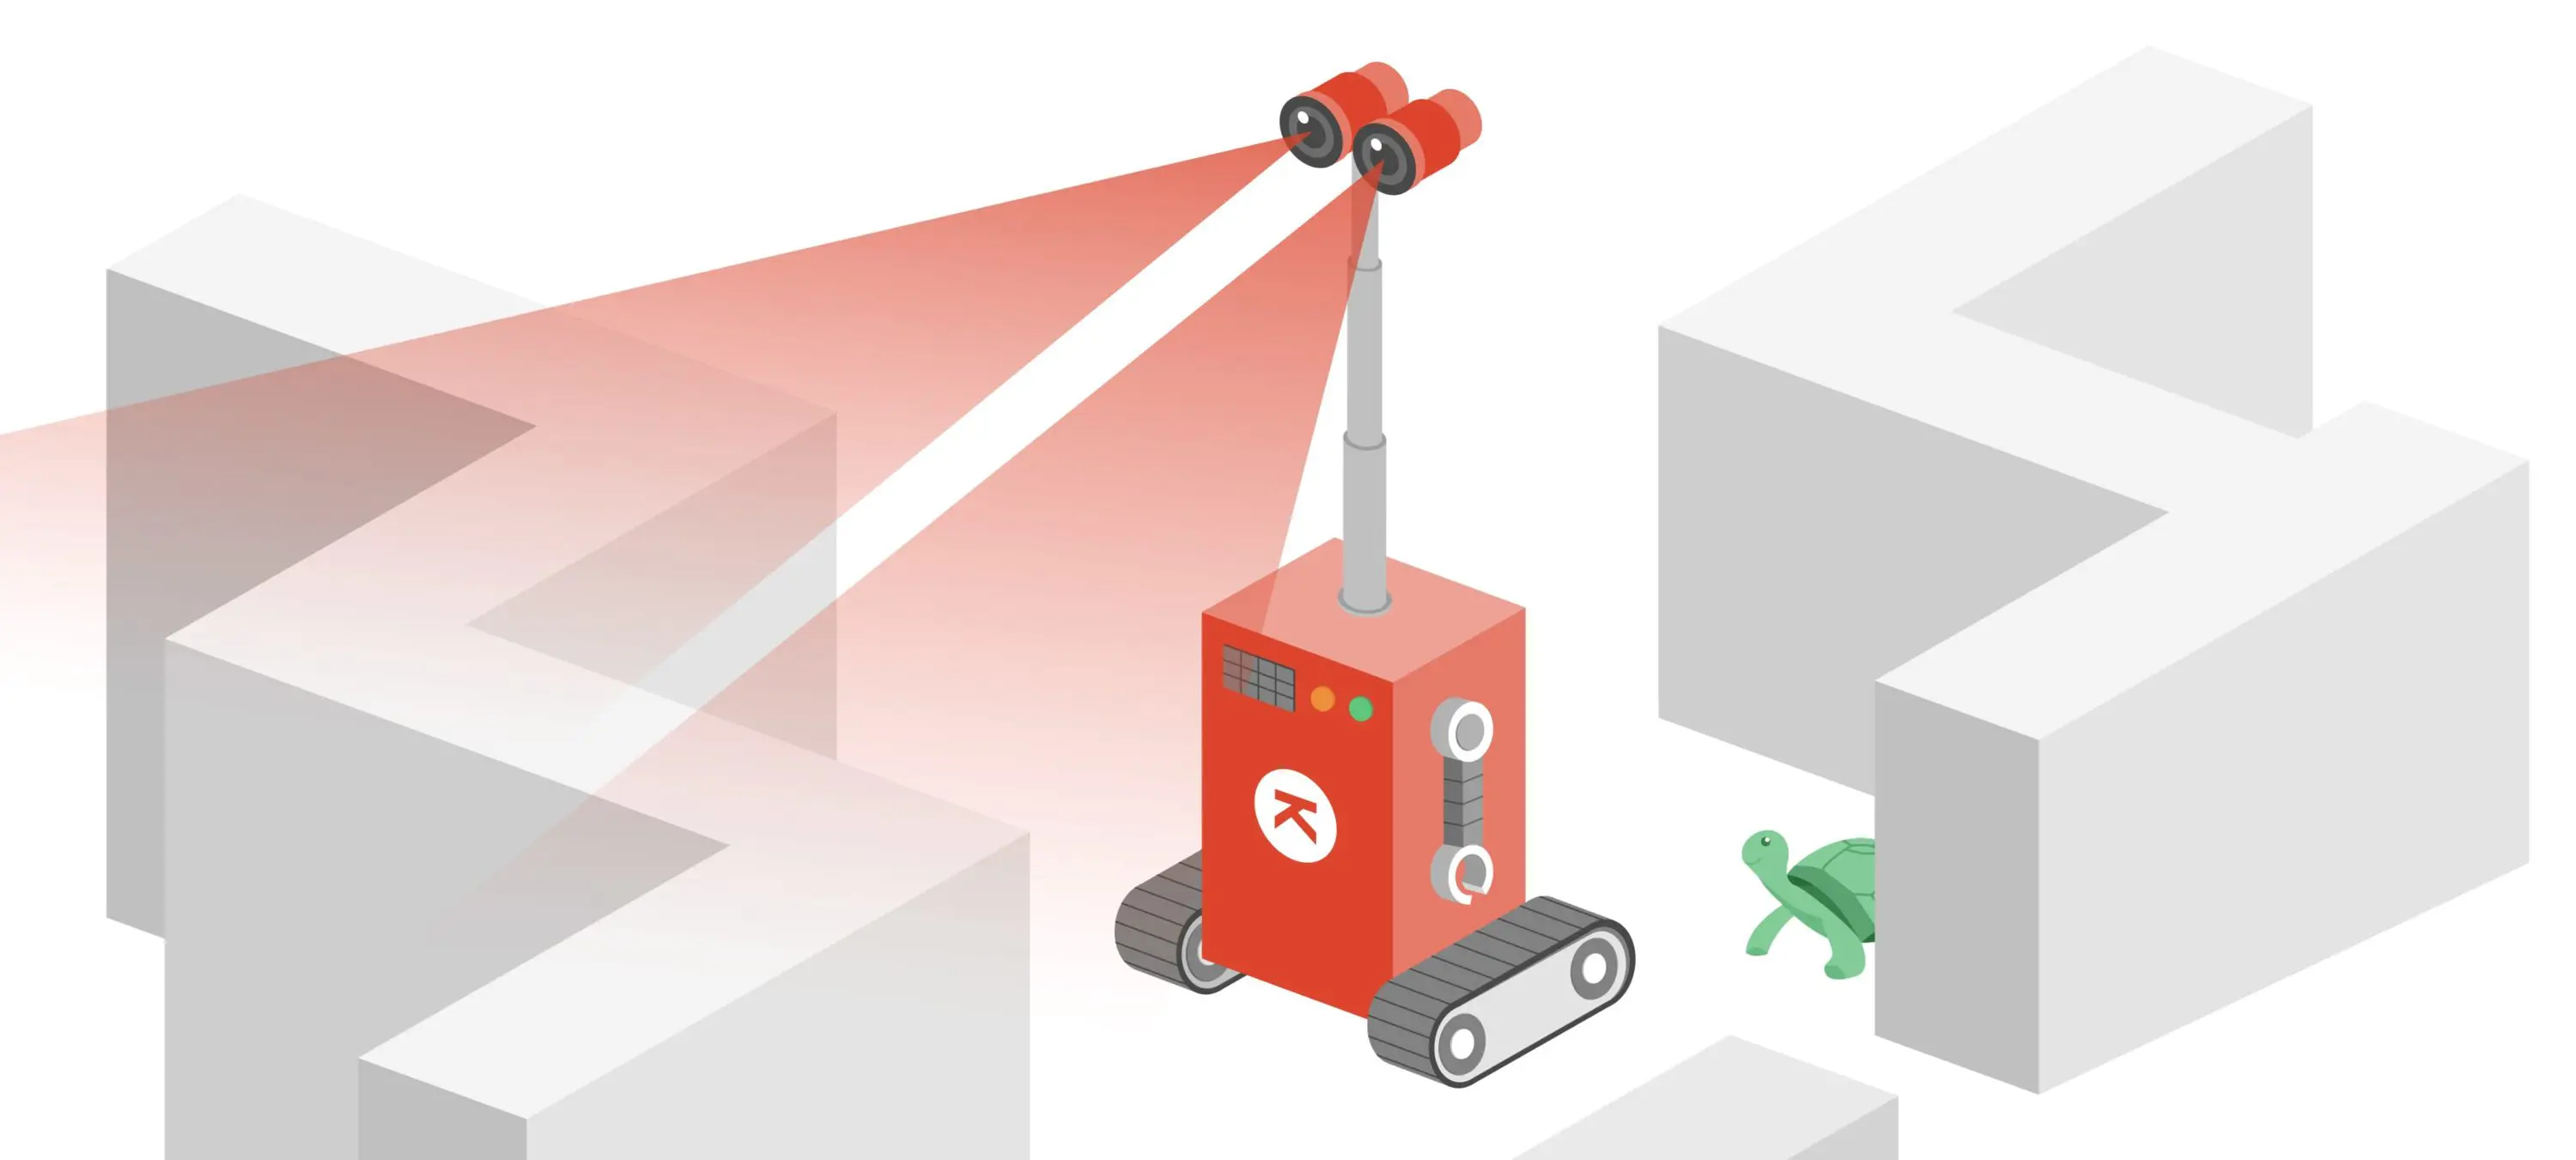

In [39]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.animation import FuncAnimation
dt = 0.1

### Implementation of Kalman Filter with Constant Velocity Model (CV)       

In constant velocity, we assume that the velocity of the ego vehicle is moving with a constant velocity. Thus, with time we don't update the velocity value in the prediction step. Instead we keep it constant.

The generic kalman filter looks like this.

<img src="kF.png" >

#### Prediction Step (Motion Model)

In the Kalman Filter (KF), the state matrix contains the parameters <u>**[Dx, Dy, Vx, Vy]**</u> of the robot.

In [19]:
x = np.matrix([0.0, 0.0, 0.0, 0.0]).T
print("The state matrix of ego robot: ", x)

The state matrix of ego robot:  [[0.]
 [0.]
 [0.]
 [0.]]


The state transition matrix <u>**F**</u> defines how the state paramters are related based on the Motion model. In kalman filter,  in the form G⋅u would represent the multiplication of the control input vector u by the control gain matrix G, resulting in a vector that represents the effect of the control input on the system's state evolution.

The motion model in KFCV is a simple linear motion model.
From this we construct the Dynamic matrix F.

$$
V = \frac{Distance}{time} \\


Dx_{t+1} = Dx_t + Vx_t \times \Delta t \\
 

Dy_{t+1} = Dy_t + Vy_t \times \Delta t \\


Vx_t = Vx_t \\
 
 
Vy_t = Vy_t \\
$$


From this we write down the state transition matrix (F).

$$
F = 
\begin{bmatrix}
1 & 0 & \Delta t & 0 \\
0 & 1 & 0 & \Delta t \\
0 & 0 & 1 & 0 \\
0 & 0 & 0 & 1 \\
\end{bmatrix}
$$


In [20]:
F = np.matrix([[1.0, 0.0, dt, 0.0], [0.0, 1.0, 0.0, dt], [0.0, 0.0, 1.0, 0.0], [0.0, 0.0, 0.0, 1.0]])
print("State Transition matrix: ", F)

State Transition matrix:  [[1.  0.  0.1 0. ]
 [0.  1.  0.  0.1]
 [0.  0.  1.  0. ]
 [0.  0.  0.  1. ]]


### Error Covariance matrix (P)

The state matrix (X) contains the means of the parameters being tracked, while the uncertainty or standard deviation of these parameters are defined in the Error Covariance matrix (P).

$$
P = 
\begin{bmatrix}
\sigma_{dx_1}^2 & 0 & 0 & 0 \\
0 & \sigma_{dy_1}^2 & 0 & 0 \\
0 & 0 & \sigma_{vx}^2 & 0 \\
0 & 0 & 0 & \sigma_{vy}^2 \\
\end{bmatrix}
$$

This is a general assumption of the KF where other than diagonal elements the matrix is filled with zeros. Yet, this is not followed in practice as if we know the prior understanding of relations between them, we can fill in thoses values. 

**Covariance:**

Covariance is a statistical measure, which define how change in one parameter shows up in the other. i.e., if X is a random variable which defines the students scores, and Y is a random variable which defines the no. of hours he studied, the covariance between the (X, Y) caluculatio based on the observed data would be positive.

Covariance can be calculated by,

$$
\text{cov}(X,Y) = E[(X - \mu_X)(Y - \mu_Y)]
$$





In order to find the covariance, we must calculate the mean of the X and Y variables, normalize the data and then find the expectation.

In [21]:
P = np.diag([10.0, 10.0, 5.0, 5.0])
print("Initial Covariance: ", P)

Initial Covariance:  [[10.  0.  0.  0.]
 [ 0. 10.  0.  0.]
 [ 0.  0.  5.  0.]
 [ 0.  0.  0.  5.]]


### Process Covariance

The Position of the vehicle can be influenced by the force of air, which disturb the car. We assume sigma a as athe magnitude of the std of acceleration

The process covariance is modelled by

$$
Q = 
\begin{bmatrix}
\sigma_{dx}^2 & 0 & \sigma_{dx}\sigma_{vx} & 0 \\
0 & \sigma_{dy}^2 & 0 & \sigma_{dy}\sigma_{vy} \\
\sigma_{vx}\sigma_{dx} & 0 & \sigma_{vx}^2 & 0 \\
0 & \sigma_{vy}\sigma_{dy} & 0 & \sigma_{vy}^2 \\
\end{bmatrix} . \sigma_{a}
$$


In order find the Q matrix, we need to first find the dependency of distance on Acceleration.

From kinematic equation,
We know that 

$$

Dx_{t+1} = Dx_t + Vx_t \times \Delta t + \frac{1}{2} \times a_t \times \Delta t^2\\
$$

From this in order to understand how the distance change w.r.t to acceleration,
we find 
$$
\sigma_{dx} = \frac{d(distance_x)}{d(acceleration_x)} = \frac{1}{2} \Delta t^2
$$

Similarly we find for velocity,
We know
$$
 \sigma_{vx} =  v = a \times t \\
    \frac{d(velocity)}{d(acceleration)} = \Delta t
$$

If we substitute them above, we get the below matrix.

Thus, we know the std_x and std_v when acceleration is acting as a process noise.

In [22]:
sv = 8.8

Q = np.matrix([[(dt**4)/4, 0.0, (dt**3)/2, 0.0], 
               [0.0, (dt**4)/4, 0.0, (dt**3)/2],
               [(dt**3)/2, 0.0, (dt**2), 0.0],
               [0.0, (dt**3)/2, 0.0, (dt**2)]]) * sv**2

print("Measurement covariance Matrix Q: ", Q)

Measurement covariance Matrix Q:  [[0.001936 0.       0.03872  0.      ]
 [0.       0.001936 0.       0.03872 ]
 [0.03872  0.       0.7744   0.      ]
 [0.       0.03872  0.       0.7744  ]]


#### Measurement Model

Assuming, we are estimating the velocity of the car based on the Wheel turnings, i.e, we have a velocity measurement sensor. And we are only predicting the X and Y components of the car. 

Then the H Measurement Matrix will look like:


$$
H = 
\begin{bmatrix}
0 & 0 & 1 & 0 \\
0 & 0 & 0 & 1 \\
\end{bmatrix}
$$

In [23]:
H = np.matrix([[0.0, 0.0, 1.0, 0.0], [0.0, 0.0, 0.0, 1.0]])
print("Measurement Matrix H :", H)

Measurement Matrix H : [[0. 0. 1. 0.]
 [0. 0. 0. 1.]]


As we are estimating the Dx and Dy, and we only get reading of Vx and Vy from sensor, we define the H matrix as above where Dx and Dy Columns are related to Vx and Vy rows.

The R matrix typically talks about how noisy the measurement data is. So, here we assumed that the noise in velocity x and y will be around 1.

In [24]:
ra = 1.0**2
R = np.matrix([[ra, 0.0], [0.0, ra]])
print("Measurement Noise Covariance Matrix R: ", R)

Measurement Noise Covariance Matrix R:  [[1. 0.]
 [0. 1.]]


In [25]:
measurementNoise = 200 # Measurements
vx= 20 # in velocity X
vy= 10 # in velocity Y

mvx = np.array(vx+np.random.randn(measurementNoise))
mvy = np.array(vy+np.random.randn(measurementNoise))
measurements = np.vstack((mvx,mvy))

print(measurements.shape)

print('Standard Deviation of Acceleration Measurements=%.2f' % np.std(mvx))
print('You assumed %.2f in R.' % R[0,0])

(2, 200)
Standard Deviation of Acceleration Measurements=0.95
You assumed 1.00 in R.


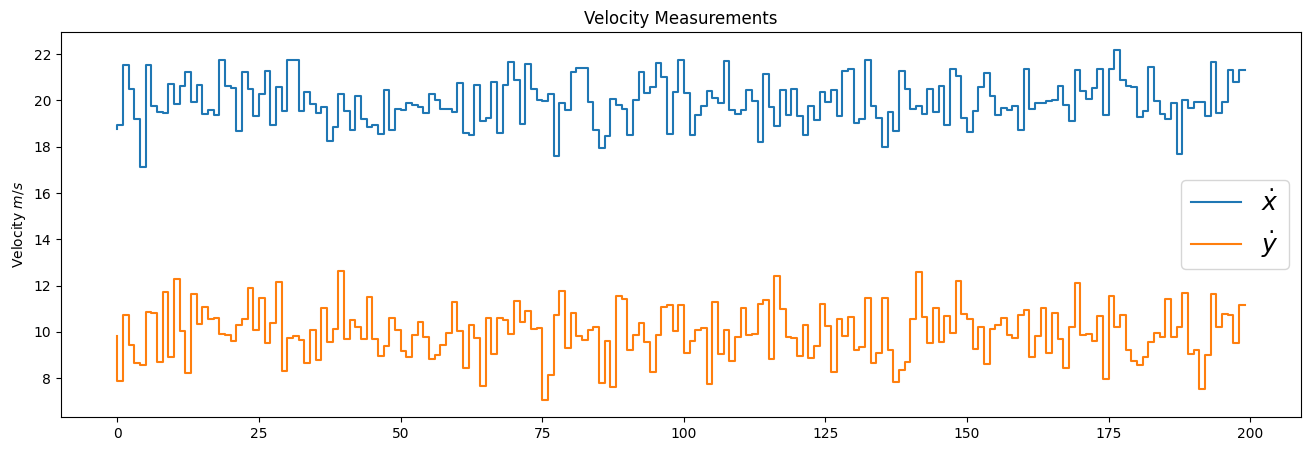

In [26]:
fig = plt.figure(figsize=(16,5))

plt.step(range(measurementNoise),mvx, label='$\dot x$')
plt.step(range(measurementNoise),mvy, label='$\dot y$')
plt.ylabel(r'Velocity $m/s$')
plt.title('Velocity Measurements')
plt.legend(loc='best',prop={'size':18})

In [27]:
# Preallocation for Plotting
xt = []
yt = []
dxt= []
dyt= []
Zx = []
Zy = []
Px = []
Py = []
Pdx= []
Pdy= []
Rdx= []
Rdy= []
Kx = []
Ky = []
Kdx= []
Kdy= []

def savestates(x, Z, P, R, K):
    xt.append(float(x[0]))
    yt.append(float(x[1]))
    dxt.append(float(x[2]))
    dyt.append(float(x[3]))
    Zx.append(float(Z[0]))
    Zy.append(float(Z[1]))
    Px.append(float(P[0,0]))
    Py.append(float(P[1,1]))
    Pdx.append(float(P[2,2]))
    Pdy.append(float(P[3,3]))
    Rdx.append(float(R[0,0]))
    Rdy.append(float(R[1,1]))
    Kx.append(float(K[0,0]))
    Ky.append(float(K[1,0]))
    Kdx.append(float(K[2,0]))
    Kdy.append(float(K[3,0]))    

In [28]:
I = np.eye(4)
print(I, I.shape)

[[1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 0. 1.]] (4, 4)


In the estimation step,

The kalman gain is calculated by 

numerator =   P * H.t (The numerator represents the variance in the predicted measurement, accounting for the uncertainty in the state estimate.)
denominator (Innovation Covariance) = H*P*H.T + R, here we are trying to find the covariance after converting the P matrix in to the measurement space and adding the R i.e, the measurement covariance. 
It is called innovation as we are incorporaing new information into the Covariance matrix.

So, S = H*P*H.T + R is called the innovation


Kalman filter weights them and find the Kalman gain.
If there is more uncertaining in the prediction then the value of Kalman gain is high, i.e, we add a bigger chunk in the below step, else we add a smaller value i.e we rely on the lienar model.

In [29]:
for n in range(len(measurements[0])):
 
    # Time Update (Prediction)
    # ========================
    # Project the state ahead
    x = F*x
    
    # Project the error covariance ahead
    P = F*P*F.T + Q
    
    
    # Measurement Update (Correction)
    # ===============================
    # Compute the Kalman Gain
    S = H*P*H.T + R
    K = (P*H.T) * np.linalg.pinv(S)

    
    # Update the estimate via z
    Z = measurements[:,n].reshape(2,1)
    y = Z - (H*x)                            # Innovation or Residual
    x = x + (K*y)
    
    # Update the error covariance
    P = (I - (K*H))*P
    
    
    # Save states (for Plotting)
    savestates(x, Z, P, R, K)

### Plotting the filtered data vs noise data of velocity

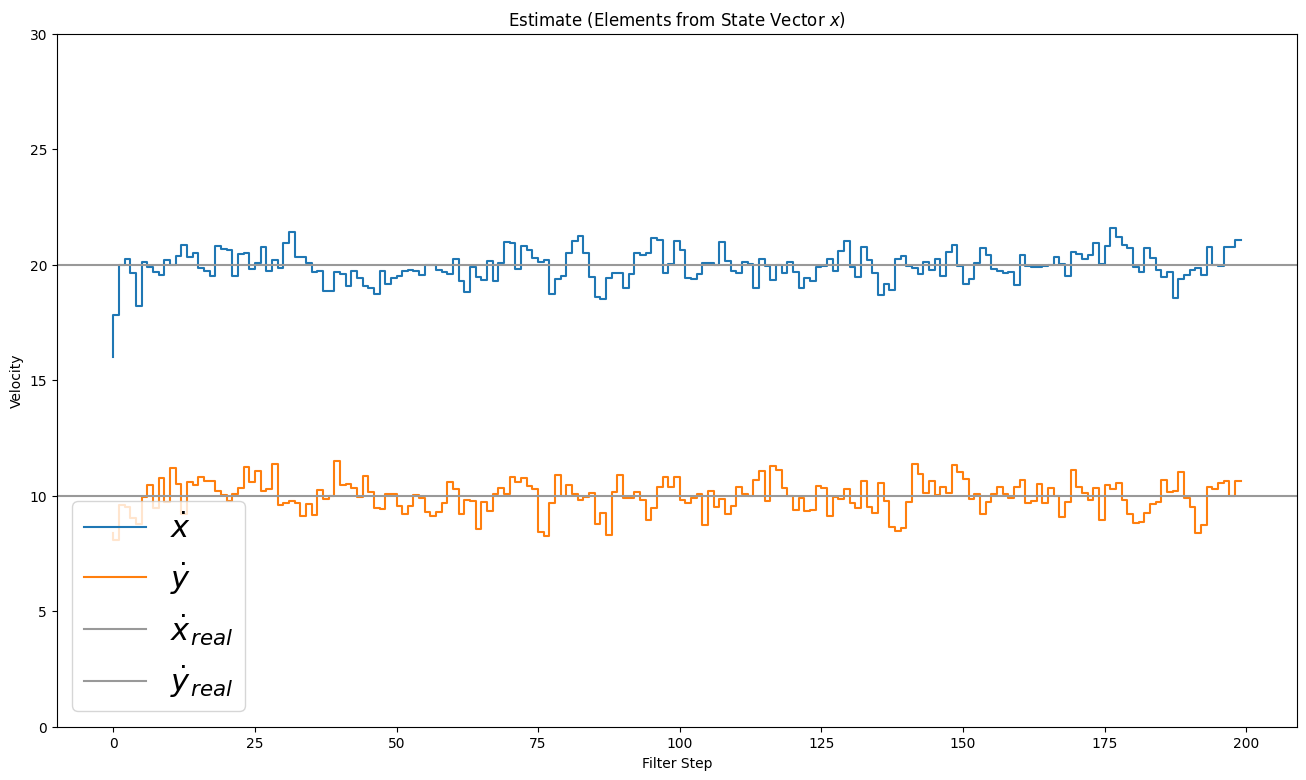

In [30]:
def plot_vxy():
    fig = plt.figure(figsize=(16,9))
    plt.step(range(len(measurements[0])),dxt, label='$\dot x$')
    plt.step(range(len(measurements[1])),dyt, label='$\dot y$')

    plt.axhline(vx, color='#999999', label='$\dot x_{real}$')
    plt.axhline(vy, color='#999999', label='$\dot y_{real}$')

    plt.xlabel('Filter Step')
    plt.title('Estimate (Elements from State Vector $x$)')
    plt.legend(loc='best',prop={'size':22})
    plt.ylim([0, 30])
    plt.ylabel('Velocity')
plot_vxy()

### Plotting the Distance prediction based on the Velocity input by kalman filter

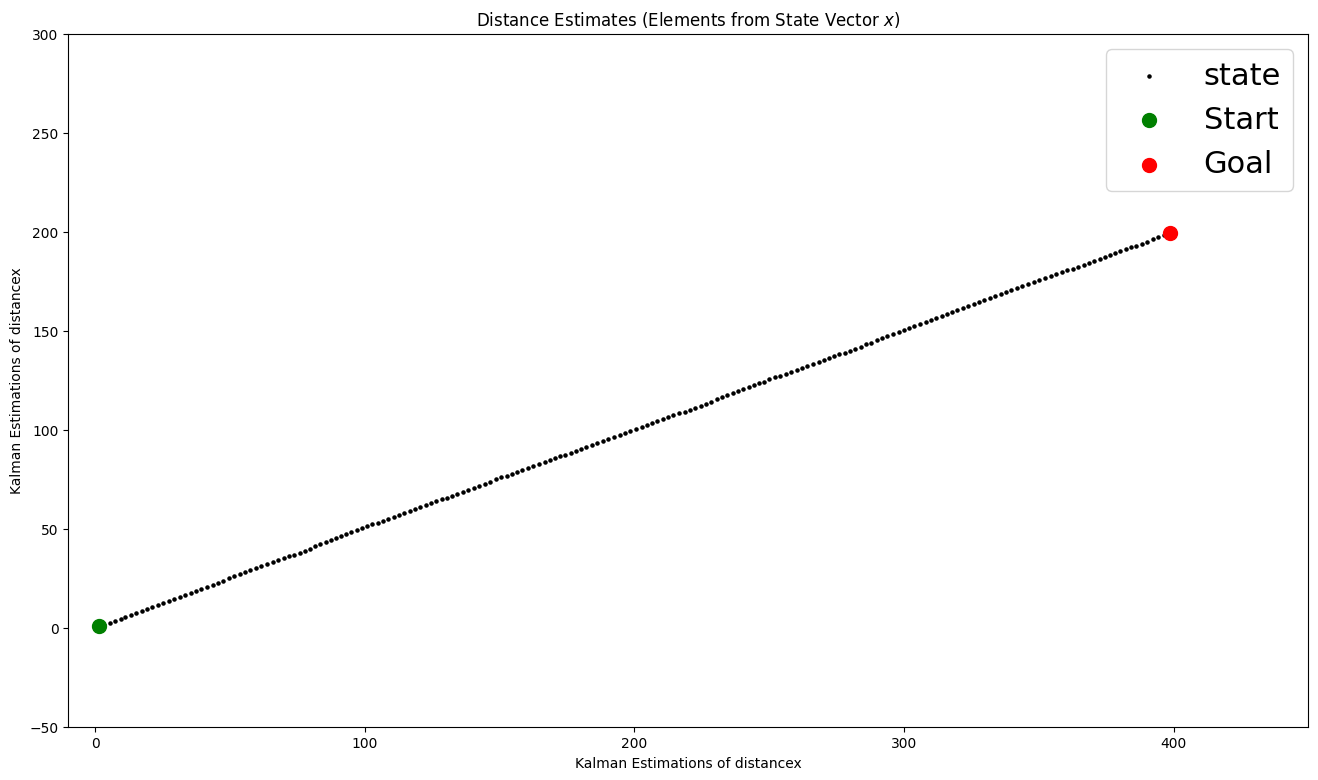

In [31]:
def plot_dxdy():
    fig = plt.figure(figsize=(16,9))
    plt.scatter(xt, yt, marker='o', s = 5, label = 'state', c='k')
    plt.scatter(xt[0], yt[0], marker='o', s = 100, label = 'Start', c='g')
    plt.scatter(xt[-1], yt[-1], marker='o', s = 100, label = 'Goal', c='r')
    plt.xlabel('Kalman Estimations of distancex')
    plt.title('Distance Estimates (Elements from State Vector $x$)')
    plt.legend(loc='best',prop={'size':22})
    plt.ylim([-50, 300])
    plt.xlim([-10, 450])
    plt.ylabel('Kalman Estimations of distancex')

plot_dxdy()

### Analysis of Kalman gains of velocity

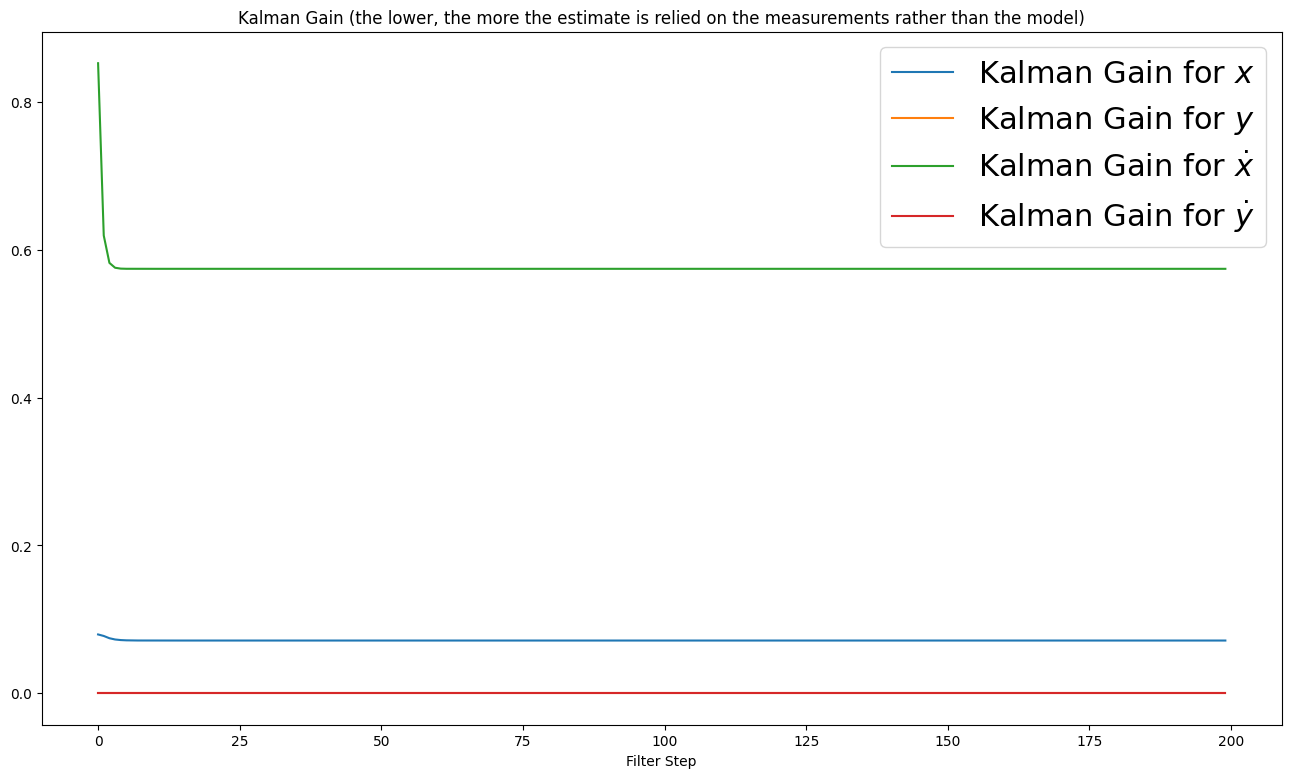

In [32]:
def plot_kalmanGain():
    fig = plt.figure(figsize=(16,9))

    plt.plot(range(len(measurements[0])), Kx, label = 'Kalman Gain for $x$')
    plt.plot(range(len(measurements[0])), Ky, label = 'Kalman Gain for $y$')
    plt.plot(range(len(measurements[0])), Kdx, label = 'Kalman Gain for $\dot x$')
    plt.plot(range(len(measurements[0])), Kdy, label = 'Kalman Gain for $\dot y$')
    plt.xlabel('Filter Step')
    plt.ylabel('')
    plt.title('Kalman Gain (the lower, the more the estimate is relied on the measurements rather than the model)')
    plt.legend(loc='best', prop={'size' : 22})
plot_kalmanGain()

### Plotting the uncertainity over the time steps around the distancex and distancey

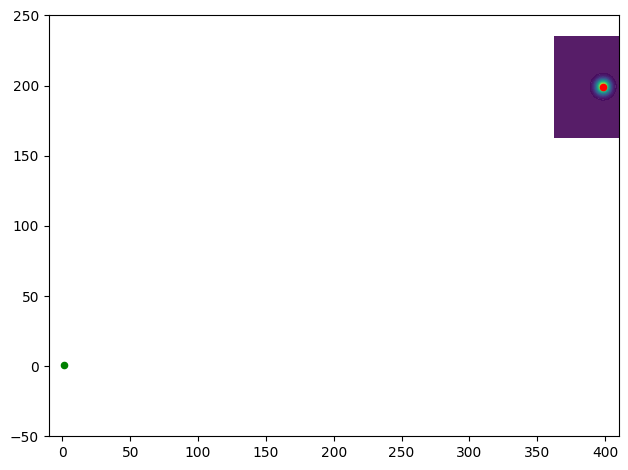

In [57]:
from scipy.stats import multivariate_normal
fig = plt.figure()
ax = plt.subplot(1, 1, 1)
dataSkip = 1

def init_func():
    plt.title('Representing the uncertainty at that time step around the location')
    plt.xlabel('X position in Map')
    plt.ylabel('Y position in Map')

def animate(i):
    ax.clear()

    #plot the gaussian
    x_spread = np.linspace(xt[i] - 3 * Px[i], xt[i] + 3 * Px[i], 100)
    y_spread = np.linspace(yt[i] - 3 * Py[i], yt[i] + 3 * Py[i], 100)
    X, Y = np.meshgrid(x_spread, y_spread)
    pos = np.dstack((X, Y))

    rv = multivariate_normal([xt[i], yt[i]], [[Px[i], 0], [0, Py[i]]])
    Z = rv.pdf(pos)
    ax.contourf(X, Y, Z, cmap='viridis', levels=50, alpha=0.9, zorder=0)

    ax.scatter(xt[i], yt[i], s=5, marker='o', c='k', label='waypoints')
    ax.scatter(xt[0], yt[0], s=20, marker='o', c='g', label='start')
    ax.scatter(xt[-1], yt[-1], s=20, marker='o', c='r', label='end')
    ax.set_ylim([-50, 250])
    ax.set_xlim([-10, 410])

ani = FuncAnimation(fig, func=animate, interval=1000, init_func=init_func, frames=np.arange(0, len(xt), dataSkip))
ani.save('animation.html', writer='html')


plt.tight_layout()
plt.show()